In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import arviz as az

Bad val "cycler('color', [348ABD, A60628, 7A68A6, 467821,D55E00,  CC79A7, 56B4E9, 009E73, F0E442, 0072B2])" on line #240
	"axes.prop_cycle    : cycler('color', [348ABD, A60628, 7A68A6, 467821,D55E00,  CC79A7, 56B4E9, 009E73, F0E442, 0072B2])  # color cycle for plot lines
"
	in file "C:\Users\zhaolei\.matplotlib\matplotlibrc"
	Key axes.prop_cycle: 'cycler('color', [348ABD, A60628, 7A68A6, 467821,D55E00,  CC79A7, 56B4E9, 009E73, F0E442, 0072B2])' is not a valid cycler construction: invalid syntax (<string>, line 1)


In [2]:
az.style.use('arviz-darkgrid')

到目前为止，我们专注于模型构建，结果解释和模型批评。 我们依靠（pm。）样本函数的魔力为我们计算后验分布。 现在，我们将专注于学习此功能背后的推理引擎的一些细节。 概率编程工具（例如PyMC3）的全部目的是用户不必关心采样是如何进行的，但是了解我们如何从后验中获取样本对于全面理解推理过程很重要，并且也可能有助于 我们了解一下这些方法何时，如何失败以及如何处理。 如果您不希望了解近似后验方法的工作原理，则可以跳过本章的大部分内容，但是我强烈建议您至少阅读“诊断样本”部分，因为本部分提供了一些准则，可帮助您检查 您的后验样本是否可靠。
有许多计算后验分布的方法。 在本章中，我们将讨论一些一般性思想，并将重点介绍在PyMC3中实现的最重要的方法。

## Inference engines
尽管从概念上讲很简单，但贝叶斯方法在数学和数值上都具有挑战性。 主要原因是，边缘可能性（贝叶斯定理中的分母）（请参见方程1.4）通常采用难以解决或计算昂贵的积分形式求解。 因此，通常使用马尔可夫链蒙特卡洛（MCMC）系列的算法或最近使用变分算法对数字进行后验估计。 这些方法有时被称为推理引擎，因为至少在原理上，它们能够近似任何概率模型的后验分布。 即使在实践中推论并不总是那么好，这种方法的存在也激发了诸如PyMC3之类的概率编程语言的发展。

概率编程语言的目标是将模型构建过程与推理过程分开，以促进模型构建，评估和模型修改/扩展的迭代步骤（如第1章“概率思维”和第2章“概率编程”中所述）。 ）。通过将推理过程（而不是模型构建过程）视为黑匣子，概率编程语言（例如PyMC3）的用户可以自由地关注其特定问题，而让PyMC3为其处理计算细节。到目前为止，这正是我们正在做的事情。因此，您可能会偏向于认为这是显而易见的或自然的方法。但是必须注意，在使用概率编程语言之前，使用概率模型的人还习惯于编写自己的抽样方法（通常针对其模型进行定制），或者用来简化模型以使其适合某些数学近似值。实际上，在某些学术界仍然如此。这种量身定制的方法可能更优雅，甚至可以提供一种更有效的后验计算方法，但是即使对于专家而言，它也容易出错且费时。此外，量身定制的方法不适用于对解决概率模型问题感兴趣的大多数从业人员。像PyMC3这样的软件邀请了具有广泛背景的人们来研究概率模型，从而降低了数学和计算入门的难度。我个人认为这太棒了，也邀请我去学习更多有关统计建模的良好实践，所以我们尽量避免自欺欺人。前面的章节主要是关于学习贝叶斯建模的基础知识的。现在，我们将在概念上学习如何实现自动推理，何时以及为何失败，以及在失败时该怎么做。

There are several methods to numerically compute the posterior. I haveordered them into two broad groups:
Non-Markovian methods
#### Grid computing
#### Quadratic approximation
#### Variational methods
Markovian methods
#### Metropolis-Hastings
#### Hamiltonian Monte Carlo
#### Sequential Monte Carlo

## Non-Markovian methods
让我们开始使用非马尔可夫方法讨论推理引擎。 在某些情况下，这些方法可以为后验提供快速，准确的近似值。
### Grid computing
网格计算是一种简单的蛮力方法。 即使您不能计算整个后验，也可以逐点计算先验和似然。 如果不是最常见的情况，这是一个非常常见的情况。 假设我们要为单个参数模型计算后验，网格近似如下：

1.为参数定义一个合理的时间间隔（先验提示）。

2.在该间隔上放置一个点网格（通常等距）。

3.对于网格中的每个点，将似然值与先验值相乘。

可选地，我们可以对计算值进行归一化，即将每个点的结果除以所有点的总和。以下代码块实现了网格方法来计算硬币翻转模型的后验：

In [12]:
def posterior_grid(grid_points=50, heads=6, tails=9):
    """ 
    A grid implementation for the coin-flipping problem 
    """
    grid = np.linspace(0, 1, grid_points)
    prior = np.repeat(1/grid_points, grid_points)  # uniform prior
    likelihood = stats.binom.pmf(heads, heads+tails, grid)  #pmf(k, n, p, loc=0)
    posterior = likelihood * prior
    posterior /= posterior.sum()
    return grid, posterior

In [54]:
grid = np.linspace(0, 1, 50)
stats.binom.pmf(6, 15, grid )
grid 

array([0.        , 0.02040816, 0.04081633, 0.06122449, 0.08163265,
       0.10204082, 0.12244898, 0.14285714, 0.16326531, 0.18367347,
       0.20408163, 0.2244898 , 0.24489796, 0.26530612, 0.28571429,
       0.30612245, 0.32653061, 0.34693878, 0.36734694, 0.3877551 ,
       0.40816327, 0.42857143, 0.44897959, 0.46938776, 0.48979592,
       0.51020408, 0.53061224, 0.55102041, 0.57142857, 0.59183673,
       0.6122449 , 0.63265306, 0.65306122, 0.67346939, 0.69387755,
       0.71428571, 0.73469388, 0.75510204, 0.7755102 , 0.79591837,
       0.81632653, 0.83673469, 0.85714286, 0.87755102, 0.89795918,
       0.91836735, 0.93877551, 0.95918367, 0.97959184, 1.        ])

Assuming we flip a coin 13 times and we observed 3 head we have:

In [15]:
data

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1])

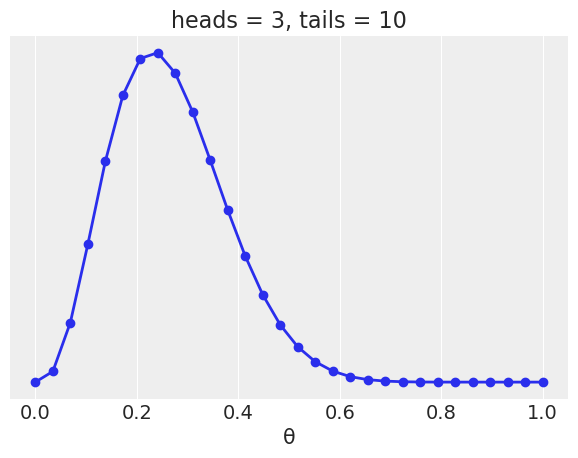

In [17]:
data = np.repeat([0, 1], (10, 3))
points = 30
h = data.sum()
t = len(data) - h
grid, posterior = posterior_grid(points, h, t) 

plt.plot(grid, posterior, 'o-')

plt.title(f'heads = {h}, tails = {t}')
plt.yticks([])
plt.xlabel('θ');
plt.savefig('B11197_08_01.png')

容易注意到，更多的点（或等效地：减小的网格大小）会产生更好的近似值。 实际上，在无限个点的限制下，我们将以增加计算资源为代价获得精确的后验。

网格方法的最大警告是，该方法在参数数量（也称为尺寸）方面无法很好地扩展。 我们可以通过一个简单的例子看到这一点。 假设像硬币翻转问题一样，我们要采样一个单位间隔（见图8.2），并且我们使用四个等距点。 这意味着0.25单位的分辨率。 现在假设我们有一个2D问题（图8.2中的正方形），并且我们想要使用具有相同分辨率的网格，我们将需要16个点，然后对于3D问题，我们将需要64个点（请参见图8.1中的多维数据集） 。 在此示例中，我们需要从面1的多维数据集中进行采样的资源是分辨率为0.25的长度为1的行的16倍。 如果我们决定需要0.1单位的分辨率，则必须为该线采样10个点，为立方体采样1000个点：

除了点数如何增加外，还有另一种现象，它不是网格方法的特性或与此有关的任何其他方法的特性，而是高维空间的特性。随着参数数量的增加，大多数后验集中的参数空间区域与采样体积相比越来越小。这是统计和机器学习中普遍存在的现象，通常被称为**维数的诅咒**，或者被数学家们称为度量集中的诅咒。维度的诅咒是用来谈论在低维空间中不存在但在高维空间中存在的各种相关现象。以下是这些现象的一些示例：

随着维数的增加，任意一对样本之间的欧几里得距离变得越来越近。也就是说，在高维空间中，大多数点之间的距离基本相同。

对于超立方体，大多数体积在其角落，而不是在中间。对于超球体，大部分体积在其表面而不是中间。

在高维中，多元高斯分布的大部分质量都不接近均值（或众数），但是在其周围的壳中，随着维数的增加，它从均值移向尾部。此外壳程序接收典型集的名称。

对于我们当前的讨论，所有这些事实意味着，如果我们不明智地选择在哪里评估后验，我们将花费大部分时间来计算对后验几乎没有贡献的值，因此，我们将浪费宝贵的资源。网格法不是一种很聪明的方法来选择评估后验分布的位置，因此，**它不是用于解决高维问题的通用方法

### Quadratic method  二次法
二次逼近也称为拉普拉斯方法或正态逼近，包括用高斯分布q（x）逼近后验p（x）。
此方法包括两个步骤：

1.找到后验分布的模式。 这将是q（x）的平均值。

2.计算Hessian矩阵。 据此，我们可以计算q（x）的标准偏差。

第一步可以使用优化方法（即找到函数的最大值或最小值的方法）在数值上完成。 为此目的，有许多现成的方法。 因为对于高斯，众数和均值相等，所以我们可以将该众数用作近似分布q（x）的均值。 第二步不是那么透明。 我们可以通过评估在q（x）的模式/平均值下的曲率来近似计算q（x）的标准偏差。 这可以通过计算Hessian矩阵的平方根的逆来完成。 Hessian矩阵是函数的二阶导数的矩阵，其逆矩阵提供协方差矩阵。 使用PyMC3，我们可以执行以下操作：(如果您尝试在PyMC3中使用（pm.find_MAP）函数，则会收到警告消息。 由于维数的诅咒，使用最大值后验（MAP）表示后验或甚至初始化采样方法通常不是一个好主意。)

In [18]:
with pm.Model() as normal_aproximation:
    p = pm.Beta('p', 1., 1.)
    w = pm.Binomial('w',n=1, p=p, observed=data)
    mean_q = pm.find_MAP()  
    std_q = ((1/pm.find_hessian(mean_q, vars=[p]))**0.5)[0]
mean_q['p'], std_q

C:\Users\zhaolei\Anaconda3\lib\site-packages\theano\gpuarray\dnn.py:184: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
  warnings.warn("Your cuDNN version is more recent than "
logp = -7.0227, ||grad|| = 4.7088e-05: 100%|██████████████████████████████████████████| 13/13 [00:00<00:00, 620.80it/s]
C:\Users\zhaolei\Anaconda3\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"
C:\Users\zhaolei\Anaconda3\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot ha

(array(0.23077285, dtype=float32), array([0.11685582], dtype=float32))

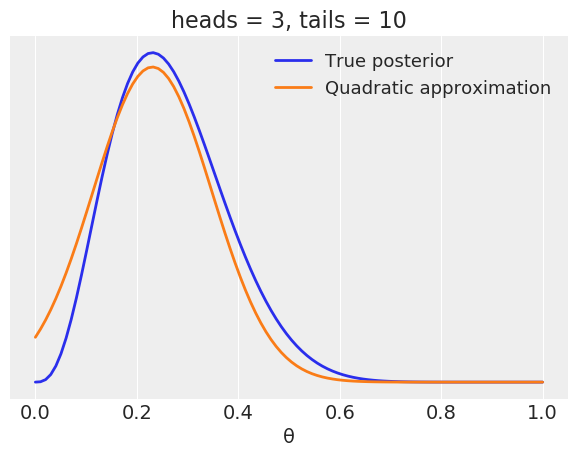

In [19]:
# analytical calculation
x = np.linspace(0, 1, 100)
plt.plot(x, stats.beta.pdf(x , h+1, t+1),
         label='True posterior')

# quadratic approximation
plt.plot(x, stats.norm.pdf(x, mean_q['p'], std_q),label='Quadratic approximation')
plt.legend(loc=0, fontsize=13)

plt.title(f'heads = {h}, tails = {t}')
plt.xlabel('θ', fontsize=14)
plt.yticks([])
plt.savefig('B11197_08_03.png');

从图8.3可以看出，至少对于本例来说，二次逼近还算不错。严格来说，我们只能将Laplace方法应用于无界变量，即存在于中的变量。这是因为高斯是无界分布，因此，如果我们使用它对有界分布（例如Beta分布）进行建模，那么最终我们将估计出正密度，而实际上密度应为零（在[0， 1]的beta分布间隔）。但是，如果我们首先转换有界变量以使其无界，则可以使用Laplace方法。例如，我们通常使用HalfNormal来精确建模标准偏差，因为它被限制在[0，∞）区间内，我们可以通过取其对数来使HalfNormal变量无界。
拉普拉斯方法是有限的，但是对于某些模型可以很好地工作，并且可以用来获得近似后验的分析表达式。这也是称为集成嵌套拉普拉斯近似（INLA）的更高级方法的组成部分之一。
在下一部分中，我们将讨论与Laplace近似在某种程度上相似但更灵活，更强大的变分方法，其中一些可以自动应用于多种模型。

## Variational methods  变分
大多数现代贝叶斯统计都是使用马尔可夫方法完成的（请参阅下一节），但是对于某些问题，这些方法可能会太慢。 对于较大的数据集（认为大数据）和/或对于计算成本过高的后代，变分方法是一种更好的选择。

变分方法的一般思想是用与Laplace方法类似的方式，但以更复杂的方式，以更简单的分布来近似后验分布。 我们可以通过解决一个优化问题来找到这种更简单的分布，该优化问题包括在某种测量紧密度的方式下找到与后部最接近的可能分布。 测量分布之间的紧密度的一种常用方法是使用Kullback-Leibler（KL）散度（如第5章，模型比较中所述）。 利用KL散度，我们可以编写：

![title](8_1.png)

表达式8.1的问题在于我们不知道后验，因此我们无法直接使用它。 我们需要找到一种替代方法来表达我们的问题。 以下步骤显示了如何执行此操作。 如果您不关心中间步骤，请跳至公式8.7。

![title](8_2.png)

![title](8_3.png)

这称为平均场近似。 平均场近似在物理学中很常见，它被用来对具有许多相互作用部分的复杂系统进行建模，将其作为根本不相互作用的较简单子系统的集合，或者通常仅对相互作用进行平均考虑。

我们可以为每个参数\ theta_j选择不同的分布q_j。 通常，q_j分布取自指数族，因为它们易于处理。 指数族包括我们在本书中使用的许多分布，例如正态，指数，β，狄利克雷，伽玛，泊松，分类和伯努利。

有了所有这些元素，我们就有效地将推理问题转化为优化问题； 因此，至少在概念上，我们需要解决的所有事情就是使用一些现成的优化器方法并最大化ELBO。 实际上，事情要复杂一些，但是我们已经涵盖了总体思路。

## Automatic differentiation variational inference 自动微分变分推理
我们刚刚描述的均值场变分方法的主要缺点是，我们必须为每种模型提出一种特定的算法。 我们没有通用推理引擎的配方，而是用于生成需要用户干预的特定于模型的方法的配方。 对我们来说幸运的是，许多人已经注意到了这个问题，并提出了针对变分方法自动化的解决方案。 最近提出的方法是自动微分变异推论（ADVI）（请参见http://arxiv.org/abs/1603.00788）。 从概念上讲，ADVI采取的主要步骤是：

变换所有有界分布，使它们实时存在，如我们在Laplace方法中所讨论的。

用高斯分布近似无界参数（这是方程8.8中的q_j）； 请注意，转换后的参数空间上的高斯不是原始参数空间上的高斯。

使用自动微分以最大化ELBO。

The PyMC3 documentation ( https://docs.pymc.io/nb_examples ) provides many examples of how to use variational inference with PyMC3.

## Markovian methods
有一系列相关方法，统称为MCMC方法。 这些随机方法使我们能够从真实的后验分布中获取样本，只要我们能够计算出似然性和先验点式。 尽管这是我们为网格法所需的相同条件，但MCMC方法的性能优于网格逼近。 这是因为MCMC方法能够从较高概率的区域中抽取更多的样本。 实际上，MCMC方法将根据其相对概率访问参数空间的每个区域。 如果区域A的可能性是区域B的两倍，那么我们将要从B获得两倍于B的样本。因此，即使我们不能解析地计算整个后验，我们也可以使用MCMC方法从中进行采样。

![title](8_4.png)

公式8.10的一个大问题是等式仅渐近成立，即对于无限数量的样本！ 实际上，我们总是有有限数量的样本，因此我们希望MCMC方法以尽可能少的样本数（也称为轮数）尽快收敛到正确的答案。

总的来说，要确定来自MCMC的特定样本已经收敛是不容易的。 因此，在实践中，我们必须依靠经验测试来确保我们拥有可靠的MCMC近似值。 我们将在“诊断样本”部分中讨论针对MCMC样本的此类测试。 重要的是要记住，其他近似值（包括本章中讨论的非马尔可夫方法）也需要经验检验，但是由于本书的重点是MCMC方法，因此我们将不讨论它们。

对MCMC方法有一个概念上的理解可以帮助我们从中诊断样本。 所以，让我问，名字叫什么？ 好吧，有时不多，有时很多。 为了理解什么是MCMC方法，我们将把该方法分为两个MC部分： 蒙特卡洛部分和马尔可夫链部分。

### Monte Carlo
The use of random numbers explains the Monte Carlo part of the name. Monte Carlo methods are a very broad family of algorithms that use random sampling to compute or simulate a given process. Monte Carlo is a very famous casino located in the Principality of Monaco. One of the developers of the Monte Carlo method, Stanislaw Ulam, had an uncle who used to gamble there. The key idea Stan had was that while many problems are difficult to solve or even formulate in an exact way, they can be effectively studied by taking samples from them. In fact, as the story goes, the motivation was to answer questions about the probability of getting a particular hand in a game of Solitary. One way to solve this problem is to follow the analytical combinatorial problem. Another way, Stan argued, is to play several games of Solitaire and count how many of the hands we play match the particular hand we are interested in! Maybe this sounds obvious to you, or at least pretty reasonable; you may even have used resampling methods to solve statistical problems. But, remember this, mental experiment was performed about 70 years ago, a time when the first practical computers began to be developed!

蒙特卡洛方法的第一个应用是解决核物理问题，这是当时使用这些工具很难解决的问题。 如今，即使是个人计算机也足够强大，可以使用蒙特卡洛方法解决许多有趣的问题。 因此，这些方法被应用于科学，工程，工业和艺术领域的各种问题。 使用蒙特卡罗方法计算感兴趣的量的一个经典的教学实例是数量的数值估计。 实际上，对于这种特殊的计算，有更好的方法，但是其教学价值仍然保留。

我们可以通过以下过程估算\pi值：
1.随机将点扔到边2R的正方形中。
2.绘制一个刻在正方形上的半径R的圆，并计算该圆内的点数。
3.估算\pi为$\frac{4 inside} {N} $比率。

![title](8_5.png)

在前面的代码中，我们可以看到outside变量仅用于获取图。 我们不需要它来计算。 还要注意，因为我们的计算仅限于单位圆； 在计算内部变量时，我们可以省略对平方根的计算。

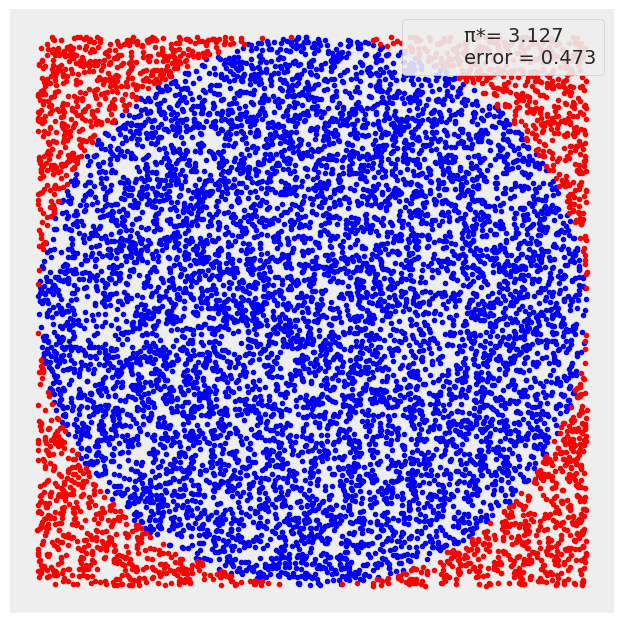

In [20]:
N = 10000

x, y = np.random.uniform(-1, 1, size=(2, N))
inside = (x**2 + y**2) <= 1
pi = inside.sum()*4/N
error = abs((pi - np.pi) / pi) * 100
 
outside = np.invert(inside)
 
plt.figure(figsize=(8, 8))
plt.plot(x[inside], y[inside], 'b.')
plt.plot(x[outside], y[outside], 'r.')
plt.plot(0, 0, label=f'π*= {pi:4.3f}\nerror = {error:4.3f}', alpha=0)
plt.axis('square')
plt.xticks([])
plt.yticks([])
    plt.legend(loc=1, frameon=True, framealpha=0.9)
plt.savefig('B11197_08_04.png');

## Markov chain
马尔可夫链是一个数学对象，由一系列状态和描述如何在状态之间移动的一组转移概率组成。如果移动到任何其他状态的概率仅取决于当前状态，则链为马尔可夫链。给定这样的链，我们可以通过选择起点并根据转移概率移至其他状态来执行随机游走。如果我们以某种方式找到了一个马尔科夫链，其转移与我们要从中采样的分布成比例（贝叶斯分析中的后验分布），则采样就变成了在该链中的状态之间移动的问题。

那么，如果我们首先不知道后验，那么如何找到该链？好吧，有一个称为详细平衡条件的东西。直观地讲，这种情况表明我们应该以可逆的方式运动（可逆的过程是物理学中的常见近似）。即，处于状态并移向状态的概率应与处于状态并移向状态的概率相同。此条件并不是真正必要的，但它已足够并且通常更容易证明，因此通常用作设计大多数最流行的MCMC方法的指南。

总而言之，如果我们设法创建一个满足此详细平衡的马尔可夫链，则可以从该链中进行抽样，并保证可以从正确的分布中获取样本。这是一个了不起的结果！以及像PyMC3这样的软件的基本引擎。

最受欢迎的马尔可夫链蒙特卡罗方法可能是Metropolis-Hasting算法，我们将在以下部分中讨论它。

## Metropolis-Hastings
对于某些分布，例如高斯分布，我们有非常有效的算法来获取样本，但是对于其他分布，情况并非如此。 Metropolis-Hastings使我们能够从任何概率分布中获取样本，因为我们可以计算至少一个与其成正比的值，从而忽略了归一化因子。 这非常有用，因为在很多问题中，不仅是贝叶斯统计问题，最难的部分是计算归一化因子。

为了从概念上理解此方法，我们将使用以下类推。 假设我们有兴趣查找湖中所含的水量，以及湖中哪一部分的水深最深。 水真的是泥泞的，所以我们不能仅通过注水到底部来估计深度，而湖真的很大，所以网格近似似乎不是一个好主意。 为了制定抽样策略，我们寻求两个最好的朋友的帮助； 马尔可夫和蒙蒂。 在进行了富有成果的讨论之后，他们提出了以下算法，该算法需要一条船-没什么花哨的，我们甚至可以使用木筏和一根很长的木棍。 这比SONAR便宜，而且我们已经把所有的钱都花在了船上！ 查看以下步骤：

1.在湖中随机选择一个地方，然后将船移到那里。
2.用木棍测量湖泊的深度。
3.将船移到另一点并进行新的测量。
4.通过以下方式比较这两个度量：
如果新斑点比第一个斑点深，请在笔记本中写下新斑点的深度，然后从步骤2开始重复。如果斑点比第一个斑点浅，我们有两个选择：接受或拒绝。 接受意味着我们记下新点的深度并从步骤2开始重复。拒绝意味着我们返回到第一个点并记下（再次是！）第一个点的深度值。

决定接受还是拒绝的规则被称为Metropolis-Hastings标准，它基本上说我们必须以与新旧斑点深度之比成正比的概率接受新斑点。

如果遵循此迭代过程，不仅将得到湖泊的总体积和最深的点，还将获得湖泊底部整个曲率的近似值。您可能已经猜到了，以此类推，湖底的曲率是后验分布，最深的点是众数。根据我们的朋友马尔可夫（Markovia）的说法，迭代次数越多，近似值越好。的确，该理论保证在某些一般情况下，如果我们获得无限数量的样本，我们将得到确切的答案。对于我们来说，幸运的是，在实践中以及对于许多很多问题，使用有限的相对少量的样本，我们可以获得非常准确的近似值。

前面的解释足以使您对Metropolis-Hastings有一个概念上的理解。接下来的几段包含更详细和正式的解释，以备您深入研究。

![title](8_6.png)

![title](8_7.png)

![title](8_8.png)

在过程的最后，我们将获得一个值列表。 如果一切都以正确的方式进行，那么这些样本将是后验的近似值。 根据后验，我们轨迹中最频繁的值将是最可能的值。 此过程的优点是，分析后验就像操作值数组一样简单，就像您在前面所有章节中已经进行的实验一样。

以下代码说明了Metropolis算法的非常基本的实现。 这并不意味着要解决任何实际问题，仅表示如果我们知道如何逐点计算其密度，就可以从概率分布中进行采样。 还要注意，以下实现中没有贝叶斯函数； 没有先例，我们甚至没有数据！ 请记住，MCMC方法是非常通用的算法，可以应用于各种各样的问题。

（Metropolis函数）的第一个参数是SciPy分布； 我们假设我们不知道如何直接从此分布中获取样本：

In [24]:
def metropolis(func, draws=10000):
    """A very simple Metropolis implementation"""
    trace = np.zeros(draws)
    old_x = 0.5  # func.mean()
    old_prob = func.pdf(old_x)

    delta = np.random.normal(0, 0.5, draws)
    for i in range(draws):
        new_x = old_x + delta[i]
        new_prob = func.pdf(new_x)
        acceptance = new_prob / old_prob
        if acceptance >= np.random.random():
            trace[i] = new_x
            old_x = new_x
            old_prob = new_prob
        else:
            trace[i] = old_x

    return trace

在下一个示例中，我们已经将func定义为beta函数，仅仅是因为它很容易更改其参数并获得不同的形状。 我们将Metropolis获得的样本绘制为直方图，并将真实分布绘制为连续（橙色）线：

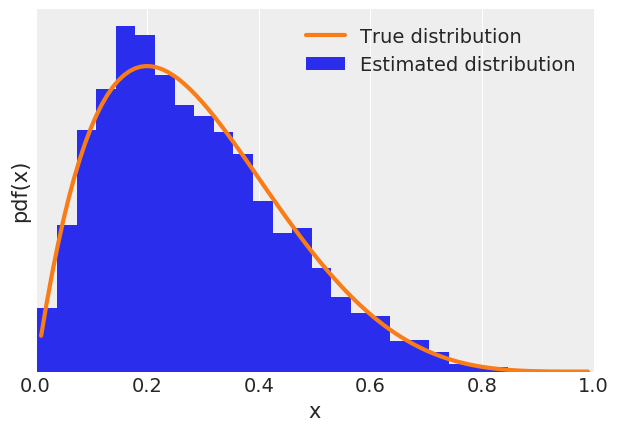

In [25]:
np.random.seed(3)
func = stats.beta(2, 5) 
trace = metropolis(func=func) 
x = np.linspace(0.01, .99, 100) 
y = func.pdf(x) 
plt.xlim(0, 1) 
plt.plot(x, y, 'C1-', lw=3, label='True distribution') 
plt.hist(trace[trace > 0], bins=25, density=True, label='Estimated distribution') 
plt.xlabel('x') 
plt.ylabel('pdf(x)')
plt.yticks([]) 
plt.legend()
plt.savefig('B11197_08_05.png');

算法的效率在很大程度上取决于提案的分布。 如果提议的状态与当前状态相距很远，则拒绝的机会非常高；如果提议的状态非常接近，则我们将非常缓慢地探索参数空间。 在这两种情况下，与极端情况下相比，我们将需要更多的样本。 通常，建议是多元高斯分布，其协方差矩阵是在调整阶段确定的。 PyMC3遵循经验法则，即一维高斯目标的理想接受度介于50％和n维高斯目标分布的理想接受度约为23％之间，从而自适应地调整协方差

MCMC方法通常需要一些时间才能开始从目标分布中获取样本。 因此，实际上，人们执行老化步骤，其中包括消除样品的第一部分。 老化是一种实用的技巧，而不是马尔可夫理论的一部分。 实际上，无穷大样本是不必要的。 因此，假设我们只能计算有限的样本，那么删除样本的第一部分只是一个临时技巧，可以获得更好的结果。 有理论保证或指导总比没有理论保证或指导要好，但是对于任何实际问题，重要的是要理解理论与实践之间的区别。 记住，不要将数学对象与这些对象的近似值混淆在一起。 球体，高斯，马尔可夫链和所有数学对象仅生活在思想的柏拉图世界中，而不是生活在我们不完美的真实世界中。

在这一点上，我希望您对Metropolis-Hastings方法有一个很好的概念性的了解。 您可能需要回头阅读本节一次或多次； 很好 主要思想很简单，但也很微妙。

### Hamiltonian Monte Carlo
MCMC方法（包括Metropolis-Hastings）具有理论上的保证，即如果我们抽取足够的样本，我们将获得正确分布的准确近似值。 但是，实际上，与获取足够的样本相比，可能要花费更多的时间。 因此，已经提出了通用Metropolis-Hastings算法的替代方案。

这些替代方法中的许多方法，例如Metropolis-Hastings算法本身，最初都是为解决统计力学中的问题而开发的，统计力学是研究原子和分子系统特性的物理学分支，因此可以使用类比法以非常自然的方式进行解释。 物理系统。 一种这样的修改被称为汉密尔顿蒙特卡洛或混合蒙特卡洛（HMC）。 简单来说，哈密顿量是对物理系统总能量的描述。 还使用了“混合”这个名称，因为它最初被认为是分子力学，一种广泛使用的分子系统模拟技术和Metropolis-Hastings的混合体。

HMC方法本质上与Metropolis-Hastings相同，这是非常非常重要的，除了提议新职位不是随机的。为了获得对HMC的一般概念了解，而无需深入数学细节，让我们再次使用湖泊和船只类比。而不是随机移动小船，而是通过跟随湖底的弯曲来实现。为了决定将船移至何处，我们从当前位置开始将球滚到湖底。我们的球是一个非常特殊的球：不仅是完美的球形，而且没有摩擦，因此不会因水或泥土而减慢速度。我们把球扔出去，让它转动一会儿，直到突然停下来。然后，我们采用Metropolis标准接受或拒绝此提议的步骤，就像我们使用香草Metropolis-Hastings方法所做的那样，整个过程重复了很多次。这种修改过的程序接受新职位的可能性更高，即使它们相对于先前职位而言距离很远。

根据参数空间的曲率移动是一种更智能的移动方式，因为它避免了Metropolis-Hastings的主要缺点之一：有效地采样空间需要拒绝大多数建议的步骤。 取而代之的是，使用HMC，即使对于参数空间中的较远点，也可以获得很高的接受率，从而导致非常有效的采样方法。

让我们离开我们的Gedanken实验，回到现实世界。 我们必须为这个非常聪明的基于汉密尔顿主义的提议付出代价。 我们需要计算函数的梯度。 梯度是将导数的概念推广到一个以上的维度； 计算某一点的函数导数可以告诉我们函数在哪个方向上增加，在哪个方向上减少。 我们可以使用梯度信息来模拟球在弯曲空间中的运动。 实际上，我们使用与经典物理学相同的运动定律和数学来模拟经典机械系统，例如滚球，行星系统的轨道和分子的摆动。

计算梯度使我们面临权衡；每个HMC步骤的计算成本都比Metropolis-Hastings步骤要高，但是HMC接受该步骤的可能性要比Metropolis高得多。为了在支持HMC的折衷情况之间取得平衡，我们需要调整HMC模型的一些参数（以与如何调整提案分布宽度的方式类似的方式来实现高效的Metropolis-Hastings采样器）。手动进行此调整时，会经历一些尝试和错误，并且还需要经验丰富的用户，这使得此过程成为我们所不希望的通用推理引擎。对我们来说幸运的是，PyMC3带有一个相对较新的采样器，称为No-U-Turn采样器（NUTS）。事实证明，此方法非常有用，可在不需要人工干预（或至少将其最小化）的情况下提供很好的求解贝叶斯模型的效率。 NUTS的一个警告是，仅适用于连续分布。原因是我们无法计算离散分布的梯度。 PyMC3通过将NUTS分配给连续参数，将Metropolis分配给离散参数来解决此问题。I strongly recommend you complement this section with this very cool animation by Chi Feng: https://chi-feng.github.io/mcmc-demo/ .

### Sequential Monte Carlo
Metropolis-Hastings和NUTS（以及其他Hamiltonian Monte Carlo变体）的警告之一是，如果后验具有多个峰，并且这些峰被极低概率区域分开，则这些方法可能会陷入单一模式而错失 其他！

为克服这个多重极小问题而开发的许多方法都基于回火的思想。 这个想法再次是从统计机制中借用的。 物理系统可以填充的状态数取决于系统的温度。 在0开氏温度（可能的最低温度）下，每个系统都处于单一状态。 另一方面，对于无限的温度，所有可能的状态都是同样可能的。 通常，我们对某些中间温度下的系统感兴趣。 对于贝叶斯模型，有一种非常直观的方法可以通过写贝叶斯定理来适应这种回火思想 tempering

![title](8_9.png)

有许多方法可以利用这个想法。 其中之一就是顺序蒙特卡洛（SMC）。 在PyMC3中实现的SMC方法可以总结如下：
1.将\ beta初始化为零。
2.从回火后验生成N个样本S_beta。
3.稍微增加\ beta。
4.计算一组N个权重W。根据新的回火后验计算权重。
5.通过根据w重新采样S_beta来获取S_w。
6.运行N个Metropolis链，从中的不同样本开始每个链。
7.从第3步开始重复，直到\ beta> = 1。

重采样步骤通过删除低概率的样本并将其替换为高概率的样本来进行。 Metropolis步骤扰动了这些样本，以帮助探索参数空间。
回火方法的效率在很大程度上取决于\ beta的中间值，通常称为冷却时间表。 两个连续的\ beta值之间的差越小，两个连续的回火后代就越接近，因此从一个阶段到下一阶段的过渡就越容易。 但是，如果步骤太小，我们将需要许多中间阶段，并且超出某些限制，这将转化为浪费大量计算资源，而实际上并没有提高结果的准确性。

幸运的是，SMC可以自动计算的中间值。 确切的冷却时间表将根据问题的难度进行调整； 与更简单的分布相比，更难以抽样的分布将需要更多的阶段。

SMC总结在图8.6中，第一个子图显示了某个特定阶段的五个样本（橙色）点。 第二个子图显示了如何根据它们的回火后密度（蓝色）曲线对这些样本进行重新加权。 第三个子图显示了从第二个子图中的重新加权样本开始，运行一定数量的Metropolis步骤的结果； 请注意如何丢弃具有较低后验密度的两个样本（最右边和左边的小圆圈），而不将它们用于播种新的马尔可夫链：

![title](8_10.png)

除了的中间值，还会根据上一阶段的接受率动态计算另外两个参数：每个马尔可夫链的步数和投标分布的宽度。

对于SMC算法的第6步，PyMC3使用Metropolis算法； 这不一定是唯一的选择，而是一个非常合理的选择，并且受到理论和实践论证的启发。 重要的是要注意，即使SMC方法使用Metropolis方法，它也比它有几个优点：

![title](8_11.png)

## Diagnosing the samples
本节重点介绍Metropolis和NUTS的诊断样本。 由于我们使用有限数量的样本来近似后验，因此检查我们是否有有效的样本非常重要，否则对样本的任何分析都将完全有缺陷。 我们可以执行几种测试，有些是视觉测试，有些是定量测试。 这些测试旨在发现样本中的问题，但无法证明我们的分布正确。 他们只能提供证明样本合理的证据。 如果我们发现样本有问题，可以尝试以下多种解决方案：
##### 增加样品数量。
##### 从跟踪的开头删除一些样本。 这就是所谓的老化。 PyMC3调整阶段有助于减少老化的需要。
##### 修改采样器参数，例如增加调整阶段的长度，或增加NUTS采样器的target_accept参数。 在某些情况下，PyMC3将提供有关更改内容的建议。
##### 重新参数化模型，即以不同但等效的方式表示模型。
##### 转换数据。 在第4章“线性模型的一般化”和第5章“模型比较”中，我们已经看到了这样的示例，我们证明了将数据居中可以改善对线性模型的采样。

为了使说明更具体，我们将使用带有两个参数的简约分层模型：全局参数a和局部参数b（每组参数）。 仅此而已，在此模型中甚至没有可能性/数据！ 我在这里省略了数据，以强调我们将要讨论的某些属性（尤其是在Divergences部分中）与模型的结构有关，而与数据无关。 我们将讨论同一模型的两个替代参数化：

In [44]:
with pm.Model() as centered_model:
    a = pm.HalfNormal('a', 10)
    b = pm.Normal('b', 0, a, shape=10)
    trace_cm = pm.sample(2000, random_seed=7,cores=1)

with pm.Model() as non_centered_model:
    a = pm.HalfNormal('a', 10)

    b_offset = pm.Normal('b_offset', mu=0, sd=1, shape=10)
    b = pm.Deterministic('b', 0 + b_offset * a)                     
    trace_ncm = pm.sample(2000, random_seed=7,cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [b, a]
Sampling chain 1, 4 divergences: 100%|████████████████████████████████████████████| 2500/2500 [00:05<00:00, 433.68it/s]
The acceptance probability does not match the target. It is 0.9322531325441712, but should be close to 0.8. Try to increase the number of tuning steps.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [b_offset, a]
Sampling chain 1, 1 divergences: 100%|████████████████████████████████████████████| 2500/2500 [00:03<00:00, 798.05it/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


中心模型和非中心模型之间的区别在于，对于前者，我们直接拟合组级参数，对于后者，我们将组级参数建模为平移和缩放的高斯模型。 我们将使用一些曲线图和数值汇总来探讨差异。

### Convergence 收敛
MCMC采样器（例如NUTS或Metropolis）可能需要一段时间才能收敛。 也就是说，它从正确的分布开始采样。 如前所述，MCMC方法在非常普通的条件下和无穷数量的样本下具有收敛的理论保证。 不幸的是，在实践中，我们只能得到有限的样本，因此，我们必须依靠经验测试，这些测试充其量只能提供提示或警告，表明失败时可能会发生不好的事情，但不能保证没有失败时一切都可以 失败。

目视检查收敛性的一种方法是运行ArviZ plot_trace函数并检查结果。 为了更好地了解检查这些图时应寻找的内容，让我们比较两个先前定义的模型的结果（见图8.6和8.7）：

注意图8.8中的KDE比8.7中的平滑。 光滑的KDE是一个好兆头，而不均匀的KDE则可能表明存在问题，例如需要更多样本或更严重的问题。 迹线本身（右边的图）应该看起来像白噪声，这意味着我们应该看不到任何可识别的图案。 我们希望曲线自由弯曲，如图8.8所示。 发生这种情况时，我们说我们混合得很好。 相反，图8.6是病理行为的一个例子。 如果仔细地将其与图8.8进行比较，将会发现8.8的两条链的重叠大于8.7，并且还会注意到在8.7迹线的多个区域中出现了一些杂乱的现象。 最清晰的一个是在500-1000次抽奖之间的区域中：您会看到链条之一（蓝色的）被卡住了（基本上是一条水平线）。

这真的，真的，真的很糟糕。 采样者拒绝所有新提议，除了附近的提议。 换句话说，它采样非常慢，因此效率不高。 对于无限样本，这不会有问题，但是对于有限样本，这会在结果中引入偏差。 一个简单的解决方案是获取更多样本，但这仅在偏差偏小时才有帮助，否则补偿偏差所需的样本数量将非常快地增长，从而使此简单的解决方案无用。

图8.9还提供了一些迹线示例，这些迹线具有良好的混合（右侧）和不良的混合（左侧）。 如果存在多个区域，例如离散变量或多峰分布，则我们希望跟踪不会在一个值或区域中花费太多时间，然后移至其他区域，而是轻松地从一个区域跳到另一个区域 ：

![title](8_12.png)

良好的MCMC样本的另一个功能是自动相似跟踪。 例如，前10％（或大约10％）应该看起来与迹线中的其他部分相似，例如后50％或10％。 再一次，我们不要模式。 相反，我们希望有一些嘈杂的声音。 也可以使用（az。 plot_trace）。 如果迹线的第一部分看起来与其他部分不同，则表明需要老化或需要更多的样本。 如果我们发现其他部分缺乏自动相似性，或者看到一种模式，则可能意味着我们需要更多绘制，但更多时候，我们应该尝试使用其他参数化。 对于困难的模型，我们甚至可能需要将所有这些策略组合使用。

默认情况下，PyMC3将尝试并行运行独立的链（确切的数目取决于可用处理器的数目）。 这是通过pm中的chains参数指定的。 样本函数。 我们可以使用plot_trace或plot_forest ArviZ函数来直观地检查平行链是否彼此相似。 然后，我们可以将并行链合并为一个链，以进行推断，因此请注意，并行运行链不会浪费资源。

C:\Users\zhaolei\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\zhaolei\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


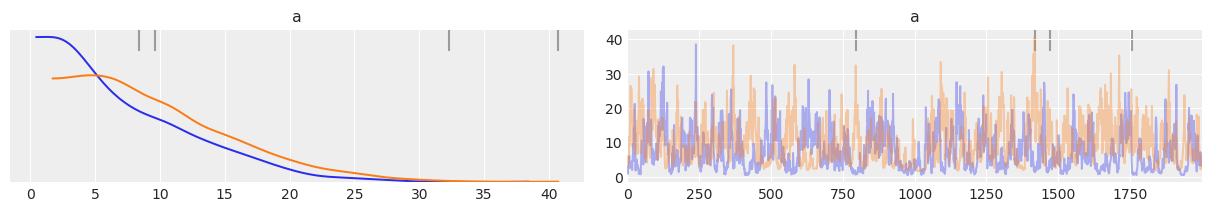

In [46]:
az.plot_trace(trace_cm, var_names=['a'], divergences='top')
plt.savefig('B11197_08_07.png');

C:\Users\zhaolei\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\zhaolei\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


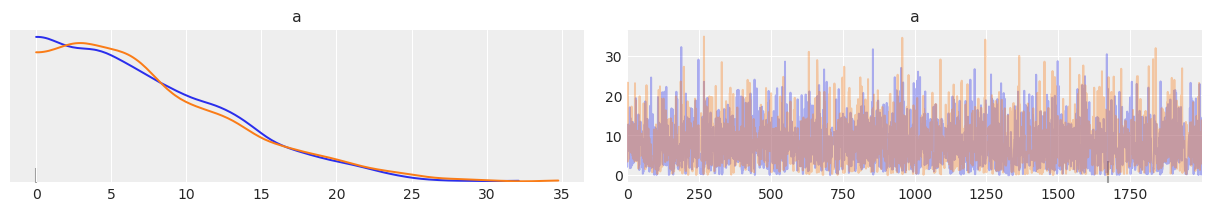

In [28]:
az.plot_trace(trace_ncm, var_names=['a'])
plt.savefig('B11197_08_08.png');

比较独立链的定量方法是使用Rhat统计量。 该测试的思想是计算链之间的方差和链内部的方差。 理想情况下，我们应该期望值为1。作为经验规则，我们可以接受小于1.1的值。 较高的值表示缺乏收敛。 我们可以使用（az。r_hat）函数进行计算； 我们只需要传递一个PyMC3跟踪对象即可。 在默认情况下，Rhat诊断也是通过（az.summary）函数（您可能在前面的章节中会回忆过）和（az.plot_forest）（使用r_hat = True参数）（可选）来计算的，如下面的示例所示 ：

In [31]:
#az.gelman_rubin(trace_cm)['a'].values

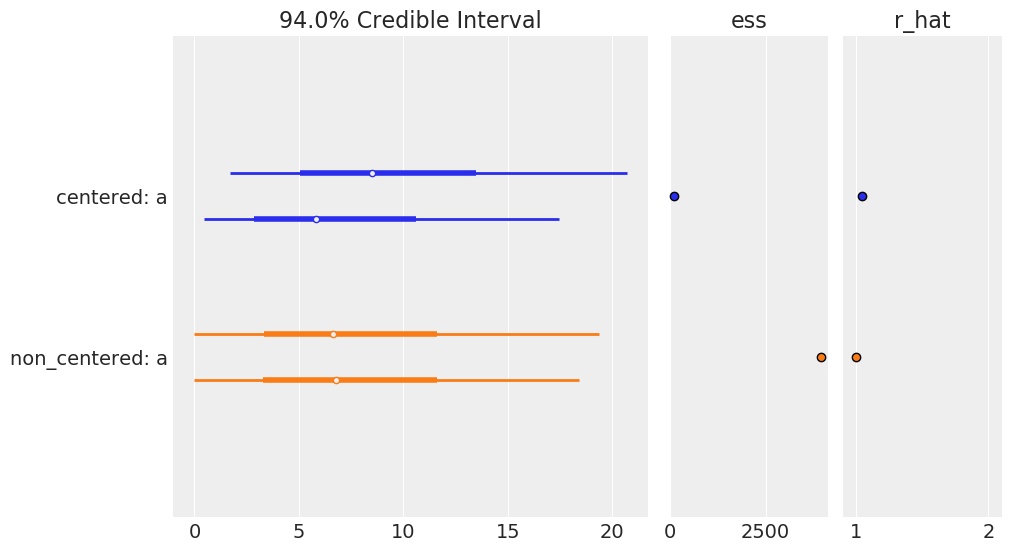

In [34]:
az.plot_forest([trace_cm, trace_ncm], model_names=['centered', 'non_centered'],
               var_names=['a'], r_hat=True,ess=True)
plt.savefig('B11197_08_10.png')

In [35]:
summaries = pd.concat([az.summary(trace_cm, var_names=['a']),
           az.summary(trace_ncm, var_names=['a'])])
summaries.index = ['centered', 'non_centered']
summaries

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
centered,8.598,6.008,0.498,19.330,0.407,0.288,218.0,218.0,176.0,359.0,1.05
non_centered,7.975,5.938,0.002,18.915,0.094,0.067,3956.0,3956.0,2866.0,1676.0,1.00


### Monte Carlo error  新的摘要已经看不见了
摘要返回的数量之一是mc_error。 这是对采样方法引入的误差的估计。 该估计考虑到样本并非真正彼此独立。 mc error是n个块的平均值x的标准误差，每个块仅是迹线的一部分：$mc_{error}=\frac{\sigma(x)}{\sqrt{n}}$
该误差应低于我们想要的结果精度。

### Autocorrelation 自相关
来自分布（包括后验）的理想样本应具有等于零的自相关（除非我们期望像时间序列那样具有相关性）。 当给定迭代中的值不独立于其他迭代中的采样值时，样本将自动相关。 实际上，从MCMC方法生成的样本将是自相关的，尤其是Metropolis-Hastings，并且在较小程度上是NUTS和SMC。 ArviZ带有一个方便的函数来绘制自相关：

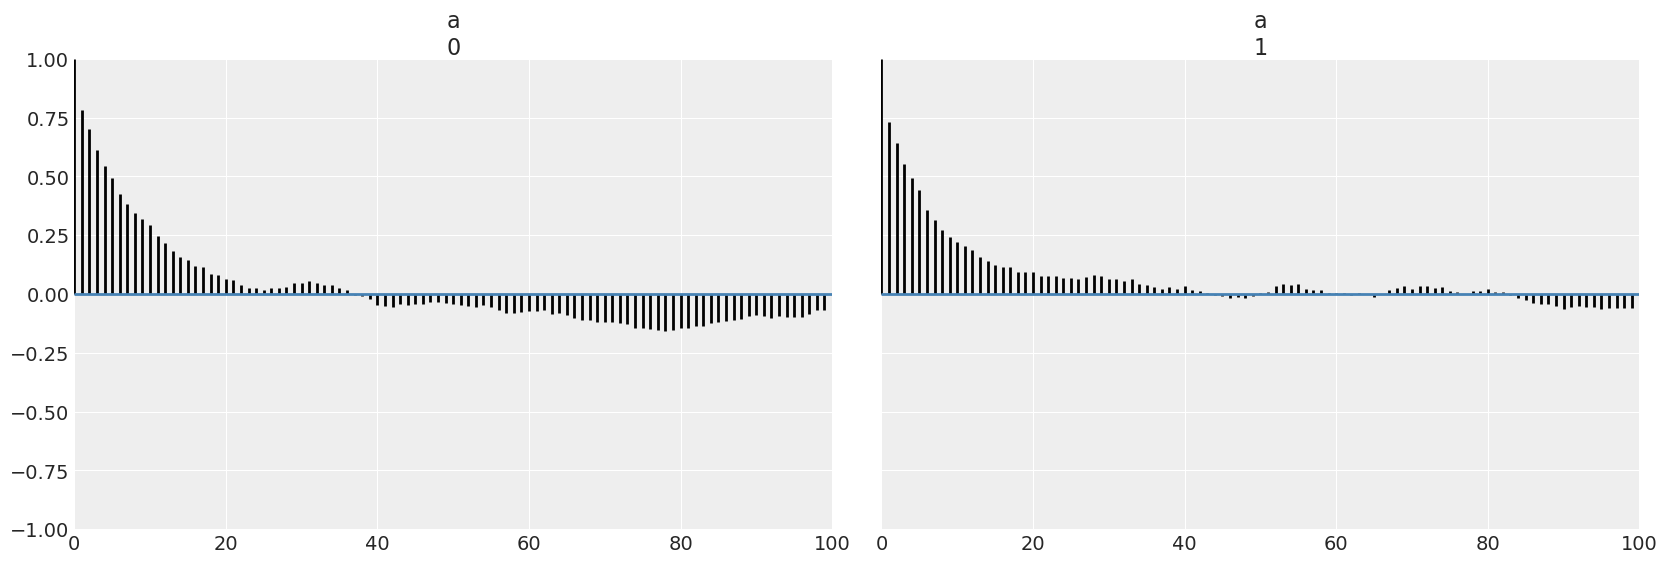

In [36]:
az.plot_autocorr(trace_cm, var_names=['a'])
plt.savefig('B11197_08_11.png');

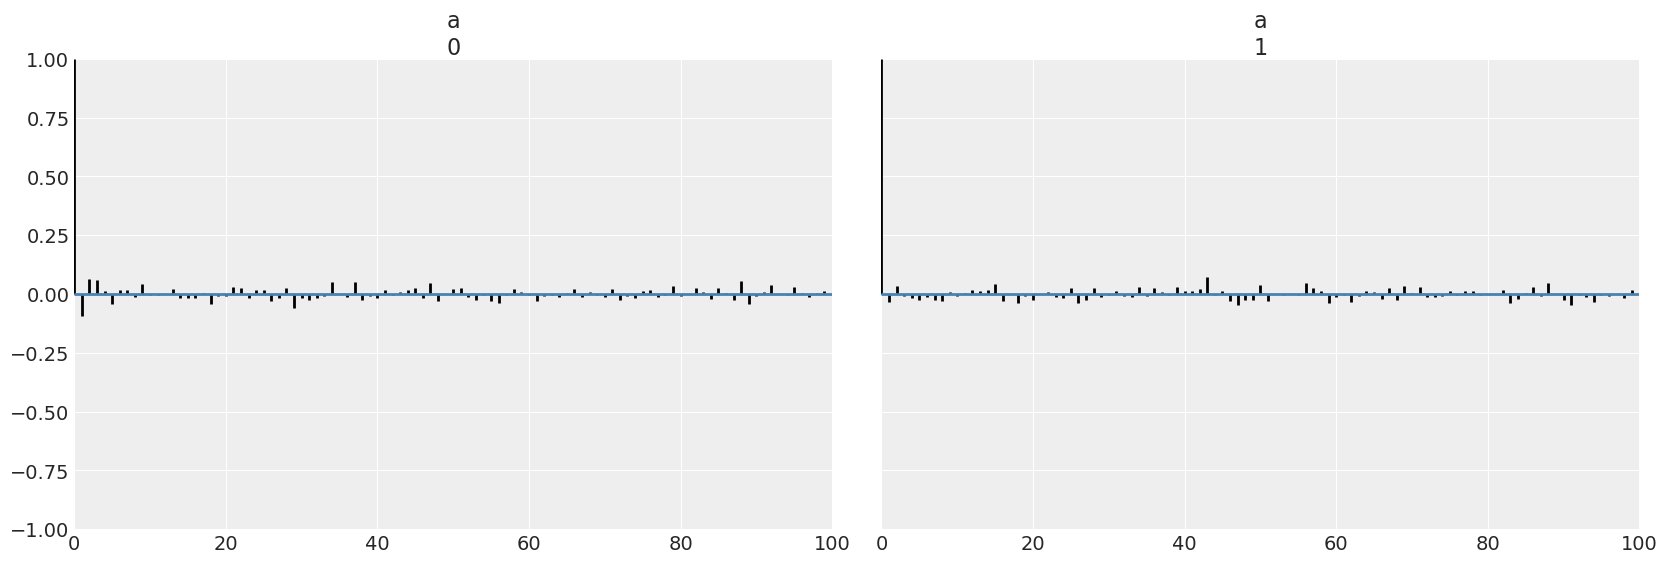

In [37]:
az.plot_autocorr(trace_ncm, var_names=['a'])
plt.savefig('B11197_08_12.png');

通过比较图8.11和8.12，我们可以很容易地看到，非中心模型的样本几乎没有自相关，而中心模型的样本显示了较大的自相关值。

## Effective sample size 有效样本量
具有自相关的样本的信息要少于没有自相关的相同大小的样本。 实际上，我们可以使用自相关来估计具有等效信息但不具有自相关的给定样本的大小。 这称为有效样本量。 参数越自相关，获得给定精度所需的样本数量就越大，换句话说，自相关具有减少有效样本数量的不利影响。 我们可以使用（az.effective_n）函数使用ArviZ计算有效样本大小。 有效样本大小也由（az。summary）（如我们在上一页和之前的章节中所做的）和（az.plot_forest）函数通过传递eff_n = True参数来计算（见图8.9）。

理想情况下，有效样本数量应接近实际样本数量。 NUTS相对于Metropolis的一个优势是NUTS的有效样本大小通常比Metropolis的大得多，因此，通常，如果您使用NUTS，则与使用Metropolis相比，通常需要的样本更少。

如果任何参数的有效样本量小于200，PyMC3都会向我们发出警告。 一般而言，100个有效样本应能很好地估计分布的平均值，但是拥有更多样本将提供估计，每次我们重新运行模型时其变化都较小，这就是您使用200个样本的原因之一 有效样本量的临界值。 对于大多数问题值，1,000到2,000个有效样本将绰绰有余。 如果我们想对取决于分布尾部或非常罕见的事件的数量进行高精度计算，我们将需要更有效的样本量。

In [41]:
#az.effective_n(trace_cm)['a'].values
az.ess(trace_cm)['a'].values

array(176.21217772)

In [42]:
az.ess(trace_ncm)['a'].values

array(2865.82715274)

## Divergences 分歧
现在，我们将探索不包含NUTS的测试，因为它们基于方法的内部工作原理，而不是所生成样本的属性。 这些测试基于所谓的差异，是诊断样本的强大而灵敏的方法。
当我尝试在本书中设置模型以避免差异时，您可能已经看到PyMC3消息表明已发生差异。 差异可能表明NUTS在其后部遇到了曲率较高的区域，因此无法正确探索。 它告诉我们采样器可能缺少参数空间的一个区域，因此我们的结果将有偏差。 差异通常比此处讨论的测试敏感得多，因此即使其余测试通过，它们也可以表示问题。 差异的一个很好的特征是它们趋向于出现在有问题的参数空间区域附近，因此我们可以使用它们来确定问题可能在哪里。 可视化差异的一种方法是将（az.plot_pair）与divergences = True参数一起使用：

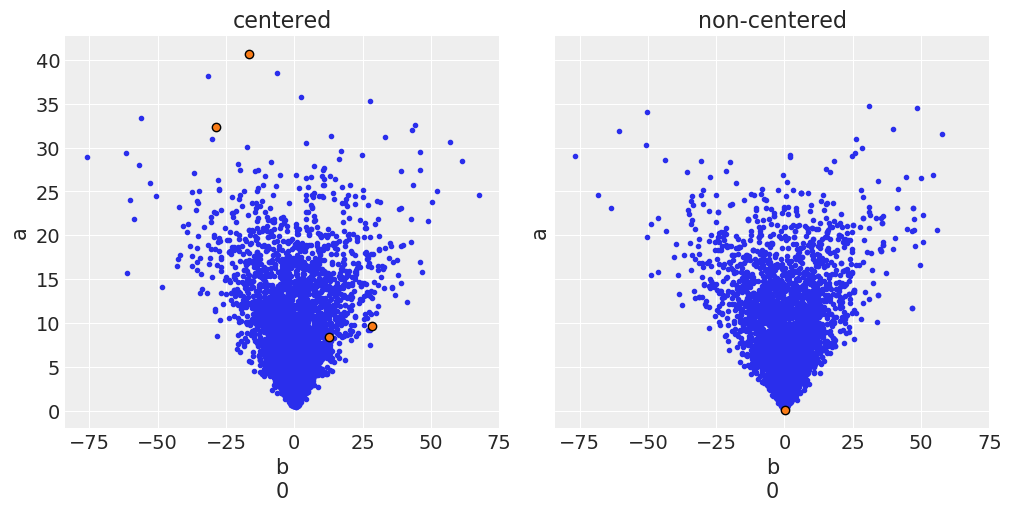

In [45]:
_, ax = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(10, 5), constrained_layout=True)

for idx, tr in enumerate([trace_cm, trace_ncm]):
    az.plot_pair(tr, var_names=['b', 'a'], coords={'b_dim_0':[0]}, kind='scatter',
                 divergences=True, contour=False, divergences_kwargs={'color':'C1'},
                 ax=ax[idx])
    ax[idx].set_title(['centered', 'non-centered'][idx])
plt.savefig('B11197_08_13.png');

在图8.13中，小（蓝色）点是规则样本，大（黑色和橙色）点表示差异。 我们可以看到居中模型的分歧较多。 我们还可以看到，非中心模型分歧较少，并且尖端更清晰。 通过这些差异，采样器告诉我们，它很难从漏斗尖端附近的区域进行采样。 我们确实可以在图8.13中检查到居中模型在尖端附近（靠近散度集中的位置）没有样本。 那有多干净？
差异也用黑色“ |”表示在ArviZ的迹线图中 标记，请参见图8.7。 请注意，散度如何集中在迹线的病理平坦部分周围。（已经没那么明显了）
可视化差异的另一种有用方法是使用平行图：

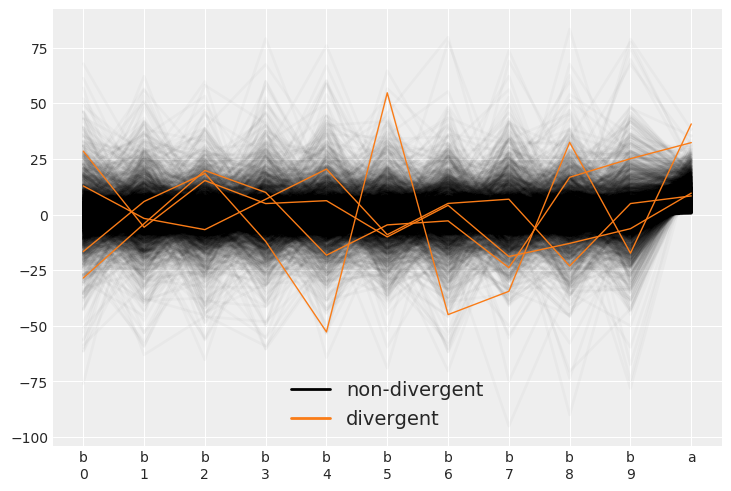

In [47]:
az.plot_parallel(trace_cm)
plt.savefig('B11197_08_14.png');

在这里，我们可以看到b和a的散度都集中在0附近。 图8.13和8.14中的图非常重要，因为它们使我们知道参数空间的哪一部分可能有问题，并且还因为它们帮助我们发现误报。 让我解释一下最后一点。 PyMC3使用启发式来标记差异，有时，这种启发式可以说我们有差异，而实际上是没有差异的。 通常，如果散度分散在参数空间中，则我们可能会有假阳性。 如果分歧集中，那么我们可能会有问题。 消除分歧时，有三种通用的方法可以消除分歧，或者至少减少分歧的数量：

#### 增加调整步骤的数量，例如[pm.sample（tune= 1000）]。

#### 从默认值0.8增加target_accept参数的值。 最大值为1，因此您可以尝试使用0.85或0.9之类的值。

#### 重新参数化模型。 正如我们所看到的，非中心模型是对中心模型的重新参数化，这会导致获得更好的样本并且不存在差异。

A better idea is to re-parameterize the model to use a non-centered parameterization for the multivariate
Gaussian varying effects prior. The word “non-centered” here is entirely unhelpful, but it is
the standard terminology, unfortunately.162 Better to say that we’re going to use a standardized adaptive
prior for the varying effects. This means the means will be zero (you’ve done this already) and
the standard deviations will all be one. Just like you can move the means to the linear model, you can
also move the standard deviations to the linear model. How? For any given Gaussian distribution,
we can always subtract out the mean and factor out the standard deviation. So for example, this:
y ~ Normal(mu; \sigma)
is equivalent to this:
y = mu+z * \sigma
z ~ Normal(0; 1)
This fact allows us to take the means and standard deviations out of a Gaussian distribution and place
them in the linear model. This leaves only a standardized multivariate Gaussian prior, with all means
at zero and standard deviations at one. Technically this is the same model. But for some models and
data, this form of the model will sample much more efficiently.

with pm.Model() as model_13_6:
    sd_dist = pm.HalfCauchy.dist(beta=2)
    pchol1 = pm.LKJCholeskyCov('pchol_actor', eta=4, n=3, sd_dist=sd_dist)
    pchol2 = pm.LKJCholeskyCov('pchol_block', eta=4, n=3, sd_dist=sd_dist)
    chol1 = pm.expand_packed_triangular(3, pchol1, lower=True)
    chol2 = pm.expand_packed_triangular(3, pchol2, lower=True)
    
    Intercept = pm.Normal('intercept', 0., 1., shape=3)
    
    beta_actor = pm.MvNormal('beta_actor', mu=0., chol=chol1, shape=(Nactor, 3))
    beta_block = pm.MvNormal('beta_block', mu=0., chol=chol2, shape=(Nblock, 3))

    A = Intercept[0] + beta_actor[actor, 0] + beta_block[block, 0]
    BP = Intercept[1] + beta_actor[actor, 1] + beta_block[block, 1]
    BPC = Intercept[2] + beta_actor[actor, 2] + beta_block[block, 2]
    
    p = pm.math.invlogit(A + (BP + BPC*d['condition'])*d['prosoc_left'])
    pulled_left = pm.Binomial('pulled_left', 1, p, observed=d['pulled_left'])

    trace_13_6 = pm.sample(5000, tune=1000,cores=1)
    
with pm.Model() as model_13_6NC:
    sd_dist = pm.HalfCauchy.dist(beta=2)
    pchol1 = pm.LKJCholeskyCov('pchol_actor', eta=4, n=3, sd_dist=sd_dist)
    pchol2 = pm.LKJCholeskyCov('pchol_block', eta=4, n=3, sd_dist=sd_dist)
    chol1 = pm.expand_packed_triangular(3, pchol1, lower=True)
    chol2 = pm.expand_packed_triangular(3, pchol2, lower=True)
    
    Intercept = pm.Normal('intercept', 0., 1., shape=3)
    
    b1 = pm.Normal('b1', 0., 1., shape=(3, Nactor))
    b2 = pm.Normal('b2', 0., 1., shape=(3, Nblock))
    beta_actor = pm.math.dot(chol1, b1)
    beta_block = pm.math.dot(chol2, b2)

    A = Intercept[0] + beta_actor[0, actor] + beta_block[0, block]
    BP = Intercept[1] + beta_actor[1, actor] + beta_block[1, block]
    BPC = Intercept[2] + beta_actor[2, actor] + beta_block[2, block]
    
    p = pm.math.invlogit(A + (BP + BPC*d['condition'])*d['prosoc_left'])
    pulled_left = pm.Binomial('pulled_left', 1, p, observed=d['pulled_left'])

    trace_13_6NC = pm.sample(5000, tune=1000,cores=1)

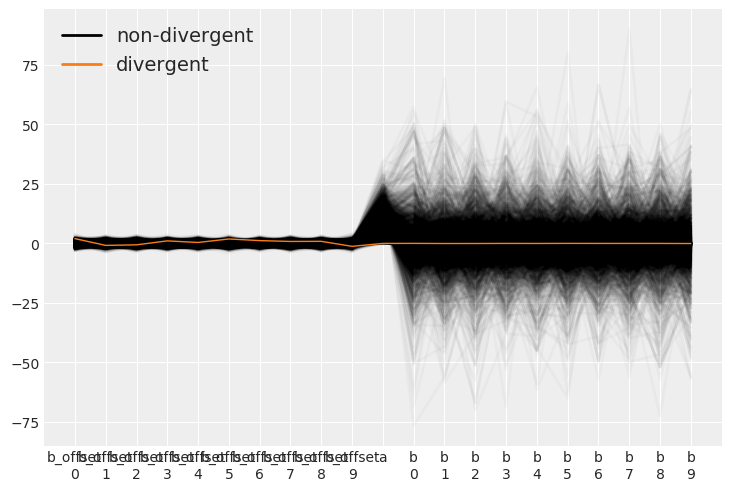

In [48]:
az.plot_parallel(trace_ncm)

## Non-centered parameterization
我已经提出了非中心模型作为解决采样问题的魔术。让我们采取行动来掩盖窍门并消除魔术。

从图8.13中，我们可以看到a和b参数是相关的。由于b是形状为10的向量，我们选择绘制b（0），但是b的任何其他元素都应显示相同的图案，实际上，这在图8.14中变得清晰可见。相关性以及此特定的漏斗形状是模型定义和模型部分合并数据的能力的结果。随着减少的值，b的各个值变得彼此更接近，并且更接近全局平均值。换句话说，收缩级别越来越高，因此数据越来越多地被合并（直到完全被合并为止）。允许部分合并的相同结构还引入了影响采样器方法性能的相关性。

在第3章“使用线性回归建模”中，我们看到了线性模型也导致了相关性（性质不同）。对于这些模型，一个简单的解决方法是将数据居中。我们可能很想在这里做同样的事情，但是不幸的是，这将无助于我们摆脱漏斗形状引入的采样问题。***漏斗形状的棘手特征是相关性随参数空间中的位置而变化，因此居中数据将无助于减少这种相关性。*** 如我们所见，MCMC方法（例如Metropolis-Hastings）在探索高度相关的空间方面存在问题。这些方法找到正确获取样本的唯一方法是在上一步的附近建议一个新步骤。结果，探索变得高度自相关并且痛苦缓慢。缓慢的混合可能会如此剧烈，以至于仅仅增加样品（抽取）的数量是不合理或不可行的解决方案。诸如NUTS之类的采样器在此工作上表现更好，因为他们基于参数空间的曲率提出了一些步骤，但是正如我们已经讨论的那样，采样过程的效率高度依赖于调整阶段。对于后验的某些几何形状（例如由分层模型引起的几何形状），调整阶段被过度调整到链开始的本地邻域，由于其他新提议更加随机，使得对其他区域的探索效率低下，类似于Metropolis-Hastings的行为。

## 总结
在本章中，我们从概念上介绍了一些用于计算后验分布的最常用方法，包括变分方法和Markov Chain Monte Carlo方法。 我们特别强调了通用推理引擎，这些引擎旨在用于任何给定模型（或至少广泛的模型）的方法。 这些方法是任何概率编程语言的核心，因为它们允许自动推断，使用户可以专注于迭代模型设计和结果解释。 我们还讨论了用于诊断样品的数值和视觉测试。 如果不能很好地近似后验分布，那么贝叶斯框架的所有优势和灵活性都将消失，因此评估推理过程的质量对于我们对推理过程本身的质量充满信心至关重要。

## Exercises
1. Use the grid approach with other priors; for example, try with prior =
(grid <= 0. 5) . astype(int) or prior = abs(grid - 0. 5) , or try defining your
own crazy priors. Experiment with other data, such as increasing the
total amount of data or making it more or less even in terms of the
number of heads you observe.

In [70]:
stats.binom.pmf(h, h+t, np.linspace(0, 1, points))

array([0.00000000e+00, 1.43343294e-23, 9.86528657e-18, 2.13370493e-14,
       4.33513609e-12, 2.39886744e-10, 5.80693216e-09, 7.91588072e-08,
       7.06365546e-07, 4.54571966e-06, 2.25343364e-05, 9.01733634e-05,
       3.01447742e-04, 8.63912374e-04, 2.16508142e-03, 4.81899144e-03,
       9.64342004e-03, 1.75198598e-02, 2.91230336e-02, 4.45707299e-02,
       6.31120816e-02, 8.30040254e-02, 1.01690769e-01, 1.16299089e-01,
       1.24330489e-01, 1.24330489e-01, 1.16299089e-01, 1.01690769e-01,
       8.30040254e-02, 6.31120816e-02, 4.45707299e-02, 2.91230336e-02,
       1.75198598e-02, 9.64342004e-03, 4.81899144e-03, 2.16508142e-03,
       8.63912374e-04, 3.01447742e-04, 9.01733634e-05, 2.25343364e-05,
       4.54571966e-06, 7.06365546e-07, 7.91588072e-08, 5.80693216e-09,
       2.39886744e-10, 4.33513609e-12, 2.13370493e-14, 9.86528657e-18,
       1.43343294e-23, 0.00000000e+00])

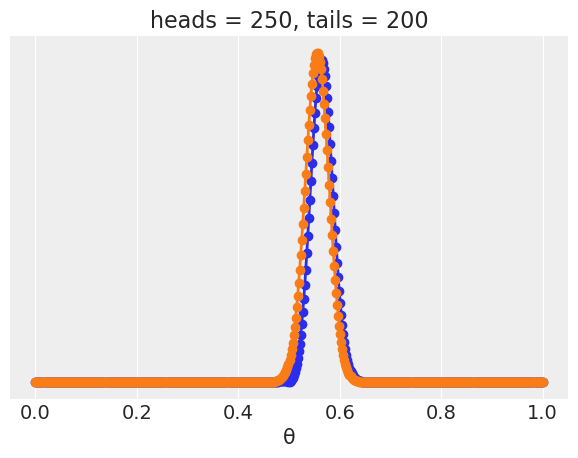

In [91]:
def posterior_grid(grid_points=50, heads=6, tails=9):
    """ 
    A grid implementation for the coin-flipping problem 
    """
    grid = np.linspace(0, 1, grid_points)
    #prior = (grid <= 0.5).astype(int)
    prior = abs(grid - 0.5)
    #prior = np.repeat(1/grid_points, grid_points)
    likelihood = stats.binom.pmf(heads, heads+tails, grid)  #pmf(k, n, p, loc=0)
    posterior = likelihood * prior
    posterior /= posterior.sum()   #posterior= posterior/posterior.sum()
    return grid, posterior
data = np.repeat([0, 1], (200, 250))
points = 500
h = data.sum()
t = len(data) - h
grid, posterior = posterior_grid(points, h, t) 

plt.plot(grid, posterior, 'o-')
plt.plot(grid,stats.binom.pmf(h, h+t, np.linspace(0, 1, points)), 'o-')
plt.title(f'heads = {h}, tails = {t}')
plt.yticks([])
plt.xlabel('θ');

2. In the code we use to estimate π, keep N fixed and re-run the code a
couple of times. Notice that the results are different because we are
using random numbers, but also check that the errors are more or less
in the same order. Try changing the number of N points and re-run the
code. Can you guesstimate how the number of N points and the error
are related? For a better estimation, you may want to modify the code
to compute the error as a function of N . You can also run the code a few
times with the same N and compute the mean error and standard
deviation of the error. You can plot these results using the plt. errorbar()
function from matplotlib. Try using a set of Ns, such as 100, 1,000,
10,000; that is a difference of one order of magnitude or so.

<ErrorbarContainer object of 3 artists>

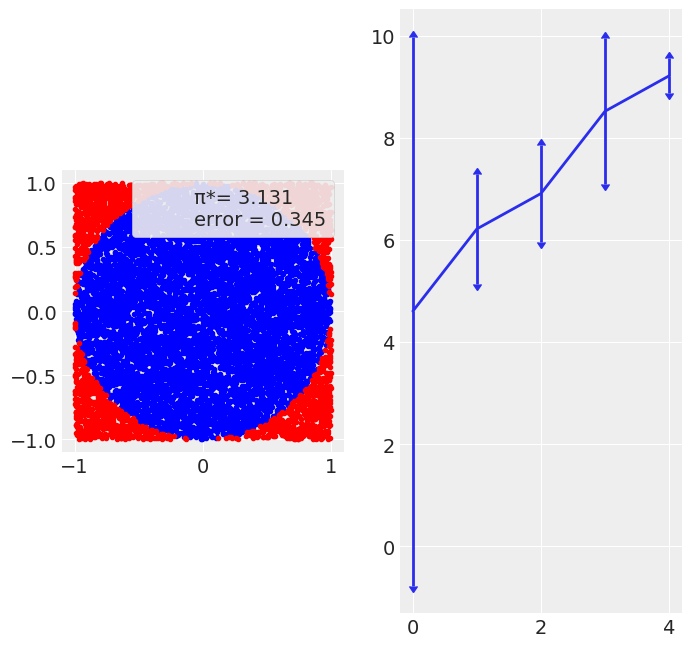

In [104]:
N = 10000
err=[]
for N in [100,500,1000,5000,10000]:
    x, y = np.random.uniform(-1, 1, size=(2, N))
    inside = (x**2 + y**2) <= 1
    pi = inside.sum()*4/N
    error = abs((pi - np.pi) / pi) * 100
    err.append(error)
 
outside = np.invert(inside)
fig, ax = plt.subplots(1,2,figsize=(8,8)) 
ax=np.ravel(ax)
ax[0].plot(x[inside], y[inside], 'b.')
ax[0].plot(x[outside], y[outside], 'r.')
ax[0].plot(0, 0, label=f'π*= {pi:4.3f}\nerror = {error:4.3f}', alpha=0)
ax[0].axis('square')
ax[0].legend(loc=1, frameon=True, framealpha=0.9)
x=range(5)
y=[100,500,1000,5000,10000]
ax[1].errorbar(x,np.log(y), yerr=err,uplims=True, lolims=True)

3. Modify the func argument you pass to the metropolis function; try using
the values of the prior from Chapter 1 , Thinking Probabilistically.
Compare this code to the grid approach; which part should be modified
to be able to use it to solve a Bayesian inference problem?
4. Compare your answer from the previous exercise to this code by
Thomas Wiecki: http: //twiecki. github. io/blog/2015/11/10/mcmc-
sampling/ http://twiecki.github.io/blog/2015/11/10/mcmc-sampling/.

In [106]:
def metropolis(func, draws=10000):
    """A very simple Metropolis implementation"""
    trace = np.zeros(draws)
    old_x = 0.5  # func.mean()
    old_prob = func.pdf(old_x)

    delta = np.random.normal(0, 0.5, draws)
    for i in range(draws):
        new_x = old_x + delta[i]
        new_prob = func.pdf(new_x)
        acceptance = new_prob / old_prob
        if acceptance >= np.random.random():
            trace[i] = new_x
            old_x = new_x
            old_prob = new_prob
        else:
            trace[i] = old_x

    return trace

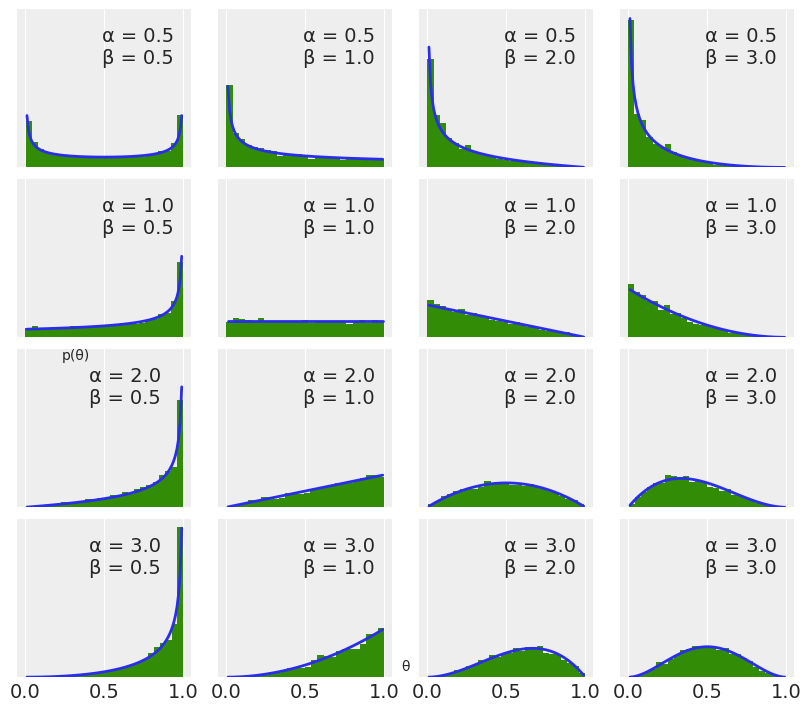

In [110]:
params = [0.5, 1, 2, 3]
x = np.linspace(0.01, .99, 100)
f, ax = plt.subplots(len(params), len(params), sharex=True, sharey=True,
                     figsize=(8, 7), constrained_layout=True)
for i in range(4):
    for j in range(4):
        np.random.seed(3)
        a = params[i]
        b = params[j]
        y = stats.beta(a, b).pdf(x)
        func = stats.beta(a, b) 
        trace = metropolis(func=func) 
        ax[i,j].plot(x, y)
        ax[i,j].plot(0, 0, label="α = {:2.1f}\nβ = {:2.1f}".format(a, b), alpha=0)
        ax[i,j].hist(trace[trace > 0], bins=25, density=True) 
        ax[i,j].legend()
ax[1,0].set_yticks([])
ax[1,0].set_xticks([0, 0.5, 1])
f.text(0.5, 0.05, 'θ', ha='center')
f.text(0.07, 0.5, 'p(θ)', va='center', rotation=0)
plt.savefig('B11197_01_04.png', dpi=300)

In [ ]:
5. Revisit at least a few of the models from previous chapters and run allthe diagnostic tools we saw in this chapter.
6. Revisit the code from all previous chapters, find those with divergences, and try to reduce the number of them.

## 引申思考
我写这本书是为了向那些已经熟悉Python和Python数据栈但对统计分析不太熟悉的人介绍贝叶斯统计的主要概念和实践。阅读了前八章后，您应该对贝叶斯统计的许多主要主题有一个合理的实践理解。尽管您不会成为Bayesian-ninja专家（无论如何）的专家，但您应该能够创建自己的概率模型来解决自己的数据分析问题。如果您真的很了解贝叶斯统计，那么这本书还不够用–可能没有一本书就足够了。要使流利的贝叶斯统计变得更加流利，您需要实践，时间，耐心，热情和更多实践，并且您需要从不同的角度重新审视思想和观念。

在存储库（https://github.com/aloctavodia/BAP）中，您将找到示例的补充，这些示例在本书中进行了讨论。由于时间或空间的原因，这些示例都不适合本书。实际上，在撰写本书时，尚无其他示例，但我会不时添加示例。要收集更多材料，您还应该在以下网址查看PyMC3文档：​​https//docs.pymc.io，尤其是“示例”部分，其中包含了本书中涵盖的许多模型示例，而其他许多则没有。如您所知，ArviZ是一个真正的新图书馆，但是我们已经在编写有关对贝叶斯模型进行探索性分析的教育资源。我们希望这将是一个有用的参考，特别是对于贝叶斯建模的新手（https//github.com/arviz-devs/arviz_resources）。

如果您在本书中发现错误，无论是文本还是代码，都可以在https: //github. com/aloctavodia/BAP提交问题。如果您有关于贝叶斯统计的一般性问题，尤其是与PyMC3或ArviZ有关的问题，https: //discourse. pymc. io/ 上提问。

在接下来的几段中，我列出了肯定会影响我的贝叶斯思维方式的一些材料。此列表绝不是详尽无遗的。我相信您还将发现本材料中的至少一部分非常有用和鼓舞人心。如果您想继续了解贝叶斯统计信息，请查看以下列表：

我强烈建议您阅读Richard的Statistics Rethinking这是一本有关贝叶斯分析的极好的入门书。问题:-)是示例在R / Stan中。因此，一群志愿者将本书中的示例移植到了Python / PyMC3中。请查看GitHub存储库以获取更多信息：https://github.com/pymcdevs/resources/tree/master/Rethinking。

另一本已移植到PyMC3的书是John K. Kruschke撰写的《做贝叶斯数据分析》（也称为小狗书）。这是关于贝叶斯分析的另一本不错的入门书。本书第一版中的大多数示例已在以下GitHub存储库中移植到Python / PyMC3：https://github.com/aloctavodia/Doing_bayesian_data_analysis。您可以在这里找到第二版：https://github.com/JWarmenhoven/DBDA-python。与统计重新思考不同，这本小狗书更着重于如何进行许多常见的频繁统计分析的贝叶斯类比。根据您的需要，这可以是本书的优点或缺点。

艾伦·B·唐尼（Allen B. Downey）有很多很棒的书，Think Bayes（http://greenteapress.com/wp/think-bayes/）也不例外。 在本书中，您将找到几个有趣的示例和方案，它们肯定会挑战您并帮助您掌握贝叶斯方法来解决问题。 本书不使用PyMC3，而是使用基于Think Bayes构建的Python库。 在本书出版时仍未编写的第二版将使用PyMC3，甚至可能使用ArviZ。 您可以检查此第二版的存储库：https://github.com/AllenDowney/ThinkBayes2

另一个（可选的免费/收费资源）是Cameron Davidson-Pilon和几位贡献者的概率编程和贝叶斯黑客方法。 这本书/笔记本最初是用PyMC2，现在已移植到PyMC3：https://github.com/quantopian/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers。

通常被称为贝叶斯书的一本书是安德鲁·盖尔曼（Andrew Gelman）等人撰写的贝叶斯数据分析书。 这虽然绝对不是入门书籍，但作为参考书而不是教科书，可能确实是一本好书。 如果您不熟悉统计信息（贝叶斯或其他统计方法），建议您首先选择Richard McElreath的Statistics Rethinking，然后尝试贝叶斯数据分析。 您可能还需要阅读Andrew Gelman和Jennifer Hill所著的《使用回归和多层次/层次模型进行数据分析》一书。

如果您想继续学习高斯过程，请阅读以下书籍：
卡尔·爱德华·拉斯穆森（Carl Edward Rasmussen）和克里斯托弗·K·威廉姆斯（Christopher K.I.Williams）所著的《高斯机器学习过程》是一本关于高斯过程的书。 它获得了国际贝叶斯分析学会2009年DeGroot奖，唯一的缺点是我们都想要一个新版本！

贝叶斯狂热者的几本机器学习书如下：
机器学习：概率概率视角，作者：Kevin P. Murphy。这是一本很棒的书，试图通过概率方法解释多少种方法和模型起作用。您可能会发现本书有些枯燥或简明扼要，具体取决于您的数学倾向。无论哪种方式，这本书都充满了示例，并且写的目的很实际。凯文·墨菲（Kevin Murphy）借鉴了许多其他来源的例子和思想，因此，本书是许多其他重要资源的摘要。我第一次听说深度学习是从这本书开始的，也就是它成为新的流行孩子之前。

Christopher Bishop撰写的模式识别和机器学习是一本关于机器学习的经典著作，与《机器学习：概率概率论》有相当多的重叠之处，尽管可能更多地涉及贝叶斯的观点。作为一本教科书，阅读起来也许比墨菲更容易，后者更像是一本参考书。

小时候，我曾梦想过飞行，清洁无限的能源，在火星或月球度假，一个追求全人类福祉的全球政府。.是的，我知道...我曾经是一个梦想家！由于许多原因，我们没有这些。取而代之的是，至少在几十年前，至少对于我来说，我们有一个完全无法想象的东西：非常强大的计算机方法的民主化。计算机革命的副作用之一是，任何对Python之类的编程语言有一定了解的人现在都可以使用大量的计算方法来进行数据分析，模拟和其他复杂任务。我认为这非常棒，但也请您特别注意这些方法。我作为一名本科生学习统计数据的方式以及必须记住如何使用固定方法的方式令人沮丧，无用，并且与所有这些更改完全无关。从个人角度而言，这本书也许是对这种令人沮丧的经历的回应。

我试图写一本统计书籍，着重介绍建模方法和明智的上下文相关分析。我不确定我在这方面是否真的成功。造成这种情况的一个原因可能是我仍然需要了解更多（也许我们作为一个社区需要了解更多有关此的信息）。另一个原因是，适当的统计分析应以领域知识和上下文为指导，并且在目标受众非常广泛的书中，通常很难提供上下文。不过，我希望我对统计模型，一些有用的示例以及足够的动力为您提供一个理智的，怀疑的观点，以便您继续学习。